In [156]:
#importowanie używanych pakietów i funkcji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn_extra.cluster import KMedoids


In [157]:
#wczytanie danych
data = pd.read_excel("dane_do_wczytania.xlsx")
#ustawiamy kolumnę "wojewodztwo" jako index
#inplace powoduje że modyfikujemy DataFrame, a nie tworzymy nowego
data.set_index("wojewodztwo",inplace=True)
#usuwamy nazwę indexu
data.index.names = [None]

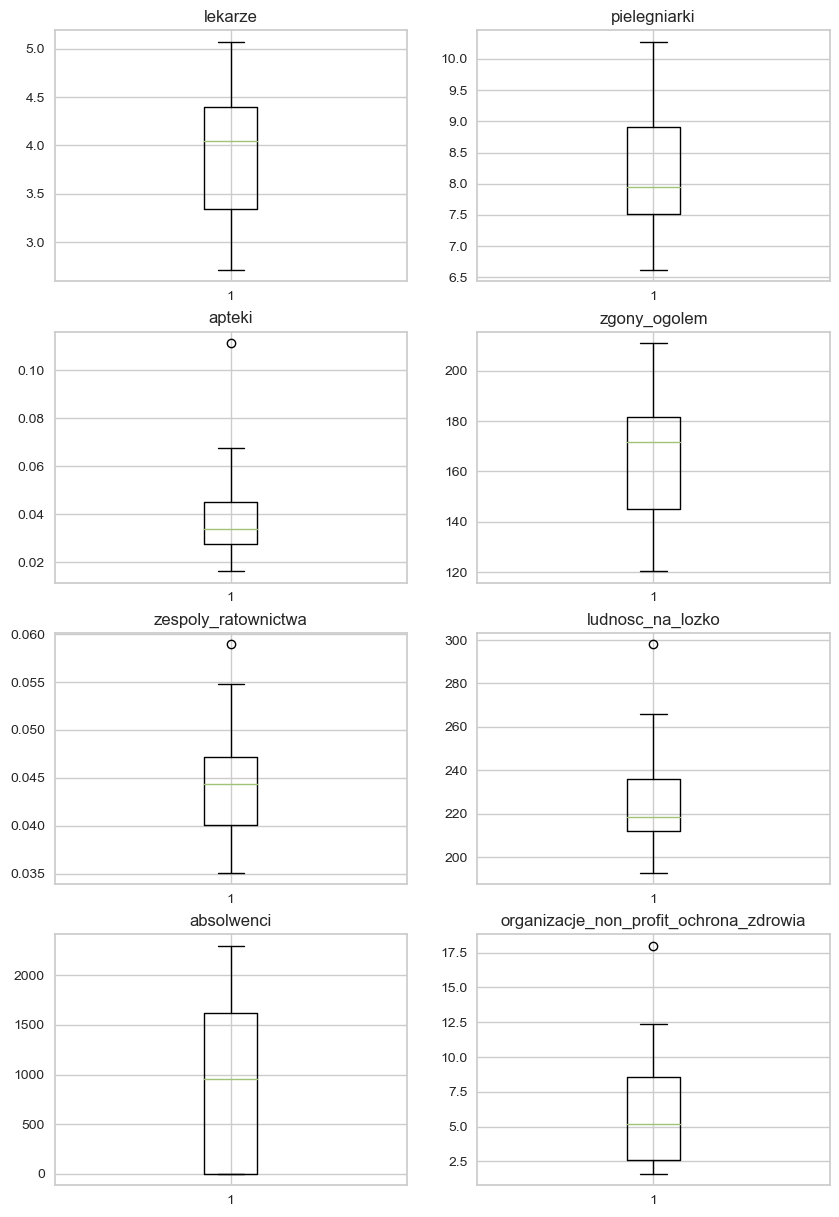

In [158]:
#podstawowe statystyki, wykresy, wartości odstające
#wykresy pudełkowe dla każdej zmiennej
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,15))
k = 0
for i in range(int(len(data.columns)/2)):
    for j in range(int(len(data.columns)/(len(data.columns)/2))):
        axes[i,j].boxplot(data[data.columns[k]])
        axes[i,j].set_title(data.columns[k])
        k+=1
    


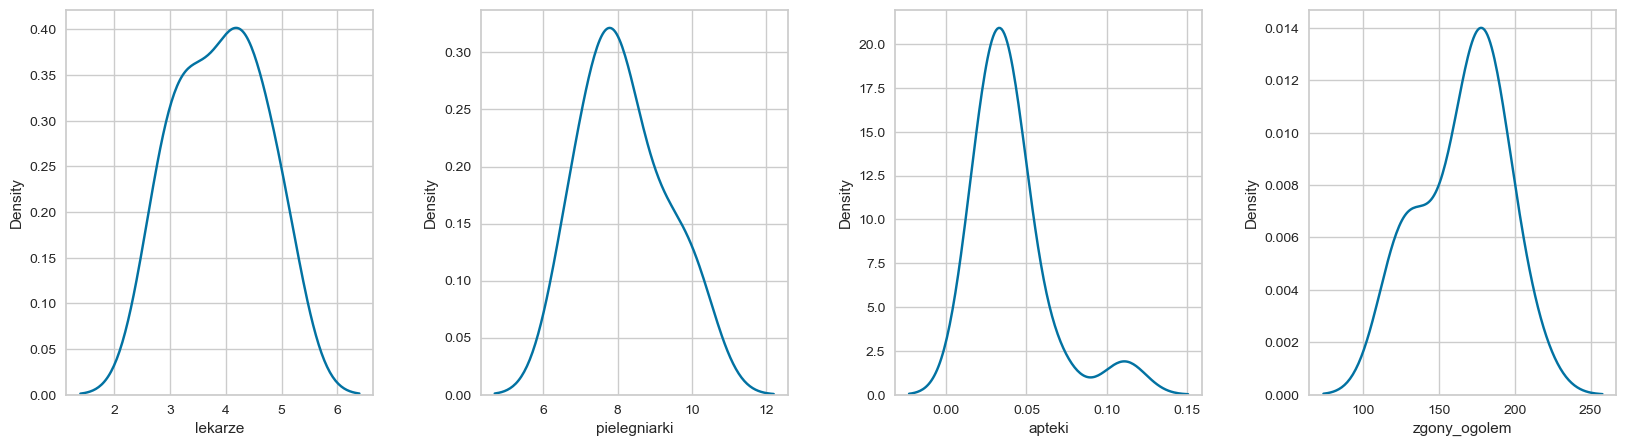

In [159]:
#wykresy gęstości zmiennych
fig, axes = plt.subplots(ncols=4,figsize=(20,5))
plt.subplots_adjust(wspace=0.35)
for i, column in enumerate(data.columns[:4]):
    sns.kdeplot(data[column], ax=axes[i])

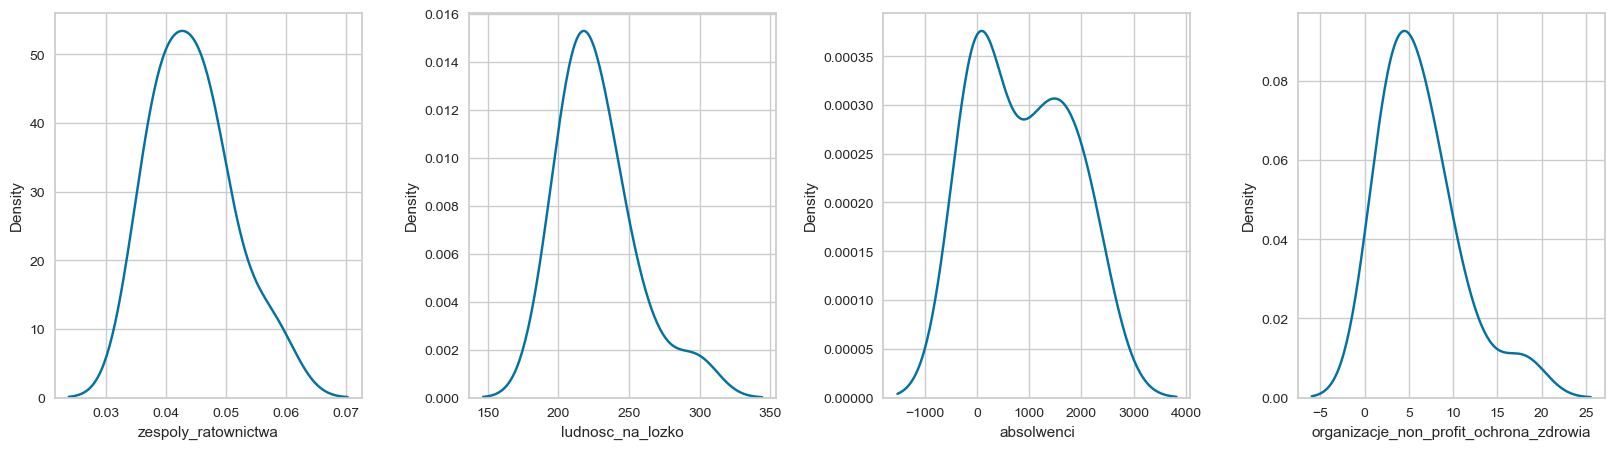

In [160]:
#wykresy gęstości zmiennych, drugi rzad
fig, axes = plt.subplots(ncols=4,figsize=(20,5))
plt.subplots_adjust(wspace=0.35)
for i, column in enumerate(data.columns[4:]):
    sns.kdeplot(data[column], ax=axes[i])

In [161]:
#przedstawienie podstawowych statystyk całego zbioru wyselekcjonowanych danych
data.describe()

,lekarze,pielegniarki,apteki,zgony_ogolem,zespoly_ratownictwa,ludnosc_na_lozko,absolwenci,organizacje_non_profit_ochrona_zdrowia
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,3.896445,8.172659,0.039537,165.631250,0.044412,227.437500,874.812500,6.243750
std,0.769269,1.121566,0.022998,27.146411,0.006595,26.857572,881.159631,4.389224
min,2.712356,6.618800,0.016341,120.300000,0.035143,193.000000,0.000000,1.600000
25%,3.339254,7.510276,0.027817,144.900000,0.040048,212.250000,0.000000,2.625000
50%,4.050560,7.939782,0.034067,171.850000,0.044317,218.500000,951.500000,5.150000
75%,4.394194,8.904232,0.045117,181.750000,0.047194,236.250000,1614.750000,8.525000
max,5.073475,10.275409,0.111246,211.100000,0.058922,298.000000,2298.000000,18.000000


In [187]:
#zamiana zmiennych na stymulanty
#liczba lekarzy - stymulanta
#liczba pielegniarek - stymulanta
#liczba aptek - stymulanta
#zgony ogolem - destymulanta
#zespoly ratownictwa medycznego - stymulanta
#liczba ludnosci na lozko szpitalne - destymulanta
#absolwenci - stymulanta
#organizacje non profit - nominanta, 8%

In [163]:
#zamiana destymulant na stymulanty
data["ludnosc_na_lozko"] = data["ludnosc_na_lozko"] * -1
data["zgony_ogolem"] = data["zgony_ogolem"] * -1
#zamiana nominanty na stymulante
nominanta = 8
for i in range(len(data["organizacje_non_profit_ochrona_zdrowia"])):
    if data["organizacje_non_profit_ochrona_zdrowia"][i]==nominanta :
        data["organizacje_non_profit_ochrona_zdrowia"][i]=1
    elif data["organizacje_non_profit_ochrona_zdrowia"][i]>nominanta :
        data["organizacje_non_profit_ochrona_zdrowia"][i] = 1/(data["organizacje_non_profit_ochrona_zdrowia"][i]-nominanta+1)
    else:
        data["organizacje_non_profit_ochrona_zdrowia"][i] = -1/(data["organizacje_non_profit_ochrona_zdrowia"][i]-nominanta-1)


In [164]:
#standaryzacja danych dla metod standaryzowanych sum i Hellwiga
data_std = data.copy()
col_names = data_std.columns
for column in col_names:
    mean = np.mean(data_std[column])
    sd = np.std(data_std[column])
    for i in range(len(data_std[column])):
        data_std[column][i] = (data_std[column][i] - mean)/sd

In [165]:
#standaryzacja danych dla metody TOPSIS
data_std_TOPSIS = data.copy()
col_names = data_std_TOPSIS.columns
for column in col_names:
    suma = np.sum(data_std_TOPSIS[column]**2)
    for i in range(len(data_std_TOPSIS[column])):
        data_std_TOPSIS[column][i] = data_std_TOPSIS[column][i]/np.sqrt(suma)

In [186]:
#metoda standaryzowanych sum

#przypisanie wag
weights = pd.DataFrame({"Name":col_names, "Weights":[0.25,0.1,0.1,0.2,0.075,0.075,0.15,0.05]})
weights = weights.transpose()
weights.rename(columns=weights.iloc[0],inplace=True)
weights.drop(weights.index[0],inplace=True)

#miara syntetyczna dla metody standaryzowanych sum
S1 = np.empty(len(data_std.index))
for i in range(len(data_std.index)):
    suma_czesciowa = 0
    for column in data_std.columns:
        suma_czesciowa += data_std[column][i]*weights[column][0]
    S1[i] = suma_czesciowa

In [167]:
#wyliczenie i dołączenie standaryzowanej miary syntetycznej do pierwotnej tabeli
miara_synt = pd.DataFrame(S1)
miara_synt.rename(columns={0:"S1"},inplace=True)
min_s1 = min(miara_synt["S1"])
s1_min_diff = miara_synt["S1"] - min_s1
miara_synt_std = s1_min_diff/np.max(s1_min_diff)

standaryzowane_sumy = data_std.copy()
standaryzowane_sumy.insert(len(standaryzowane_sumy.columns),"S1",miara_synt["S1"].values)
standaryzowane_sumy.insert(len(standaryzowane_sumy.columns),"S2",miara_synt_std.values)

#posortowanie tabeli danych według wyliczonej miary
standaryzowane_sumy.sort_values("S2",inplace=True,ascending=False)
standaryzowane_sumy.drop(columns=standaryzowane_sumy.columns[range(9)])


,S2
MAZOWIECKIE,1.000000
SLASKIE,0.886398
PODLASKIE,0.821959
LUBELSKIE,0.778469
LODZKIE,0.777691
DOLNOSLASKIE,0.751242
MALOPOLSKIE,0.736129
POMORSKIE,0.587049
WIELKOPOLSKIE,0.547890
PODKARPACKIE,0.401121


In [168]:
#metoda Hellwiga
wzorzec = np.empty(len(data_std.columns))

#wyznaczenie wzorca
i=0
for column in data_std.columns:
    wzorzec[i] = max(data_std[column])
    i+=1

#wyliczenie odległości obiektów od wzorca
di = np.empty(len(data_std.index))
for i in range(len(data_std.index)):
    suma=0
    j=0
    for column in data_std.columns:
        suma += weights[column][0]*(data_std[column][i] - wzorzec[j])**2
        j+=1
    di[i]=np.sqrt(suma)

#wyliczenie odległości "możliwie dalekiej" i miary syntetycznej
d0 = np.mean(di) + 2*np.std(di)
si = 1 - di/d0

#połączenie wyliczonej miary z danymi
metoda_Hellwiga = data_std.copy()
metoda_Hellwiga.insert(len(metoda_Hellwiga.columns),"Si",si)

#posortowanie danych według miary
metoda_Hellwiga.sort_values("Si",inplace=True,ascending=False)
metoda_Hellwiga.drop(columns=metoda_Hellwiga.columns[range(8)])



,Si
DOLNOSLASKIE,0.405122
MAZOWIECKIE,0.397152
SLASKIE,0.384435
PODLASKIE,0.359871
MALOPOLSKIE,0.357344
LUBELSKIE,0.346385
LODZKIE,0.325131
POMORSKIE,0.227327
WIELKOPOLSKIE,0.219074
PODKARPACKIE,0.217807


In [169]:
#metoda TOPSIS
#wyliczenie wzorca i antywzorca
wzorzec = np.empty(len(data_std_TOPSIS.columns))
antywzorzec = np.empty(len(data_std_TOPSIS.columns))

i=0
for column in data_std_TOPSIS.columns:
    wzorzec[i] = max(data_std_TOPSIS[column])
    antywzorzec[i] = min(data_std_TOPSIS[column])
    i+=1

#wyliczenie odległości między obiektami a wzorcem i antywzorcem
dip = np.empty(len(data_std_TOPSIS.index)) #di+ (plus)
dim = np.empty(len(data_std_TOPSIS.index)) #di- (minus)
for i in range(len(data_std_TOPSIS.index)):
    suma_p=0
    suma_m=0
    j=0
    for column in data_std_TOPSIS.columns:
        suma_p += weights[column][0]*(data_std_TOPSIS[column][i] - wzorzec[j])**2
        suma_m += weights[column][0]*(data_std_TOPSIS[column][i] - antywzorzec[j])**2
        j+=1
    dip[i]=np.sqrt(suma_p)
    dim[i]=np.sqrt(suma_m)

#wyliczenie miary
R = dim/(dim+dip)

#dołączenie miary do danych oraz sortowanie według niej
metoda_TOPSIS = data_std_TOPSIS.copy()
metoda_TOPSIS.insert(len(metoda_TOPSIS.columns),"R",R)
metoda_TOPSIS.sort_values("R",inplace=True,ascending=False)
metoda_TOPSIS.drop(columns=metoda_TOPSIS.columns[range(8)])

,R
SLASKIE,0.691835
WIELKOPOLSKIE,0.562609
MAZOWIECKIE,0.543936
LODZKIE,0.528245
DOLNOSLASKIE,0.516026
LUBELSKIE,0.436884
MALOPOLSKIE,0.416272
POMORSKIE,0.411691
PODLASKIE,0.366967
ZACHODNIOPOMORSKIE,0.262830


In [170]:
#metoda sumy rang
data_ranked = data.copy()

#zamiana wartości zmiennych na rangi
for column in data_ranked.columns:
    data_ranked.sort_values(column,inplace=True,ascending=False)
    for i in range(len(data_ranked.index)):
        data_ranked[column][i] = i+1

#wyliczenie sumy rang dla obiektu
si = np.empty(len(data_ranked.index))
for i in range(len(data_ranked.index)):
    suma=0
    for column in data_ranked.columns:
        suma+=data_ranked[column][i]*weights[column][0]
    si[i]=suma

#dołączenie sumy rang do obiektów i sortowanie według niej
metoda_sumy_rang = data_ranked.copy()
metoda_sumy_rang.insert(len(metoda_sumy_rang.columns),"Si",si)
metoda_sumy_rang.sort_values("Si",inplace=True,ascending=True)
metoda_sumy_rang.drop(columns=metoda_sumy_rang.columns[range(8)])


,Si
MAZOWIECKIE,5.350
DOLNOSLASKIE,5.875
LODZKIE,6.400
PODLASKIE,6.400
SLASKIE,6.550
LUBELSKIE,6.925
POMORSKIE,7.575
MALOPOLSKIE,8.075
WIELKOPOLSKIE,8.525
PODKARPACKIE,9.175


In [172]:
#analiza skupień
#ponowne wczytanie i standaryzacja danych dla ułatwienia kodowania
data = pd.read_excel("dane_do_wczytania.xlsx")
data.set_index("wojewodztwo",inplace=True)
data.index.names = [None]
data_std = data.copy()
col_names = data_std.columns
for column in col_names:
    mean = np.mean(data_std[column])
    sd = np.std(data_std[column])
    for i in range(len(data_std[column])):
        data_std[column][i] = (data_std[column][i] - mean)/sd

Text(0.5, 0, 'Liczba grup')

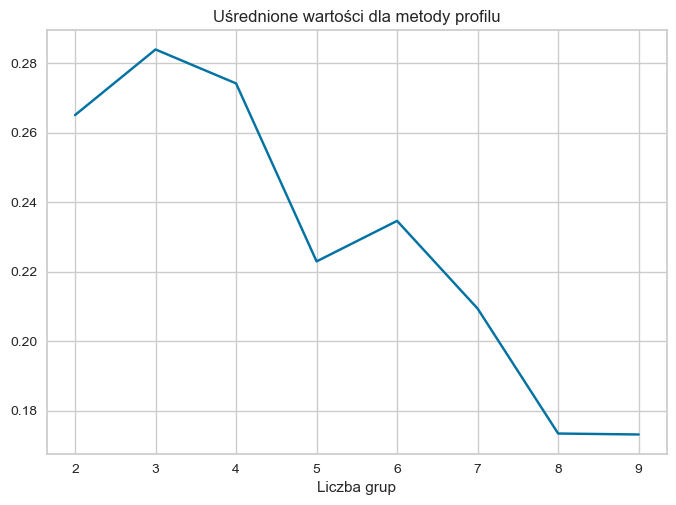

In [174]:
#metoda profilu
#sprawdzenie wyników metody profilu dla różnej liczby grup
s_scores = []
for i in range(2,10):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit_predict(data_std)
    s_score = silhouette_score(data_std, km.labels_, metric='euclidean')
    s_scores.append(s_score)
plt.plot(range(2,10),s_scores)
plt.title("Uśrednione wartości dla metody profilu")
plt.xlabel("Liczba grup")


Text(0.5, 0, 'Liczba grup')

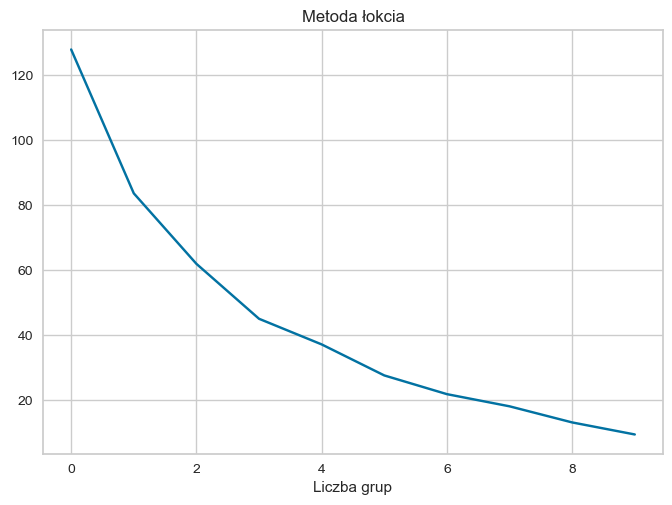

In [176]:
#metoda łokcia
#wyliczenie wartości dla metody łokcia w zależności od liczby grup
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(data_std)
    wcss.append(km.inertia_)
plt.plot(wcss)
plt.title("Metoda łokcia")
plt.xlabel("Liczba grup")

Text(0.5, 1.0, 'Grupy według metody k-średnich')

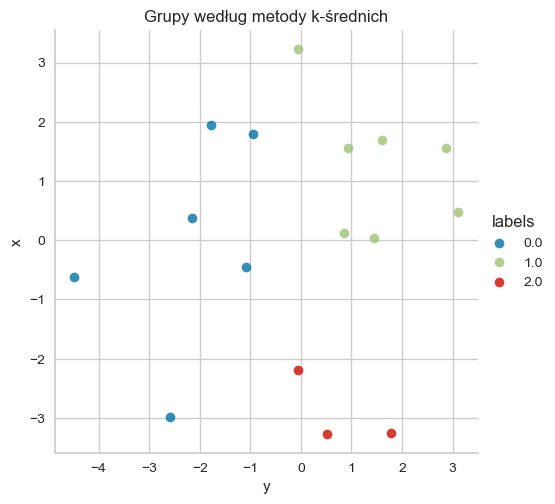

In [177]:
#stworzenie i dopasowanie modelu dla wybranej liczby grup
km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmfit = km.fit(data_std)
#dodanie kolumny odpowiedzialnej za numer grupy do tabeli 
data_std_grouped = data_std.copy()
data_grouped = data.copy()
data_grouped.insert(len(data_grouped.columns),"Group",kmfit.labels_)
data_grouped.sort_values("Group",inplace=True)

#skalowanie danych wielowymiarowych do dwuwymiarowych w celu wizualizacji
mds = MDS(random_state=0)
data_std_2d = mds.fit_transform(data_std)
#dołączenie do dwuwymiarowych danych numerów grup, zamiana arraya w dataframe i zmiana nazw
data_std_2d_kmeans = np.c_[data_std_2d, kmfit.labels_]
data_std_2d_kmeans = pd.DataFrame(data_std_2d_kmeans)
data_std_2d_kmeans.columns = ["x","y","labels"]
#przedstawienie na wykresie dwuwymiarowym grup obiektów
sns.lmplot(x='y',y='x',data=data_std_2d_kmeans,hue='labels', fit_reg=False)
plt.title("Grupy według metody k-średnich")

In [178]:
#wypisanie województw razem z numerem grupy do której zostały przypisane w metodzie k-średnich
data_grouped["Group"]

SLASKIE                0
DOLNOSLASKIE           0
LODZKIE                0
LUBELSKIE              0
PODLASKIE              0
MAZOWIECKIE            0
LUBUSKIE               1
ZACHODNIOPOMORSKIE     1
OPOLSKIE               1
KUJAWSKO-POMORSKIE     1
WARMINSKO-MAZURSKIE    1
SWIETOKRZYSKIE         1
PODKARPACKIE           1
MALOPOLSKIE            2
WIELKOPOLSKIE          2
POMORSKIE              2
Name: Group, dtype: int32

In [179]:
#wypisanie podstawowych statystyk dla każdej zmiennej według
for col in data_grouped.columns:
    print("\n",col,"\n",data_grouped.groupby("Group")[col].describe(percentiles=[0.5]))


 lekarze 
        count      mean       std       min       50%       max
Group                                                         
0        6.0  4.666697  0.358434  4.225597  4.657972  5.073475
1        7.0  3.225341  0.438608  2.712356  3.170768  3.950255
2        3.0  3.921852  0.427583  3.428542  4.150864  4.186151

 pielegniarki 
        count      mean       std       min       50%        max
Group                                                          
0        6.0  8.649497  0.831859  7.728029  8.544811   9.972526
1        7.0  8.245839  1.233361  6.950857  7.682403  10.275409
2        3.0  7.048229  0.737180  6.618800  6.626447   7.899439

 apteki 
        count      mean       std       min       50%       max
Group                                                         
0        6.0  0.049261  0.032388  0.018279  0.045227  0.111246
1        7.0  0.027491  0.007214  0.016341  0.030918  0.035414
2        3.0  0.048197  0.016855  0.036075  0.041072  0.067444

 zgony_og

Text(0.5, 1.0, 'Grupy według metody k-medoid')

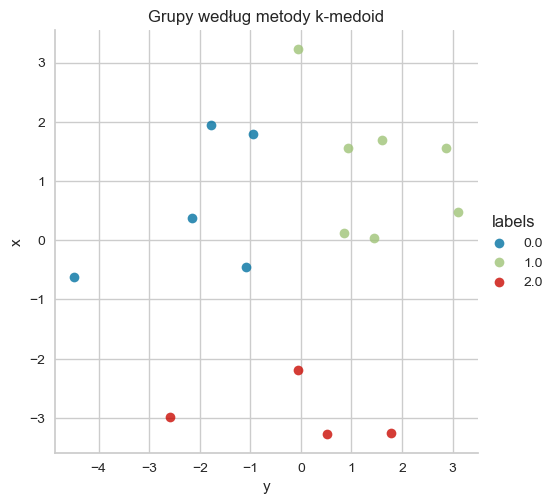

In [181]:
#grupowanie podziałowe, metoda k-medoid
#stworzenie i dopasowanie modelu dla metody k-medoid
kmedoids = KMedoids(n_clusters=3, random_state=0, max_iter=300, init="k-medoids++").fit(data_std)
#stworzenie tabeli danych razem z numerami grup przypisanymi metodą k-medoid
data_std_grouped2 = data_std.copy()
data_grouped2 = data.copy()
data_grouped2.insert(len(data_std_grouped2.columns),"Group",kmedoids.labels_)
data_grouped2.sort_values("Group",inplace=True)
#stworzenie dataframe z przypisanymi numerami grup uzyskanymi z metody k-medoid na podstawie wcześniej skalowanych danych
data_std_2d_kmedoids = np.c_[data_std_2d, kmedoids.labels_]
data_std_2d_kmedoids = pd.DataFrame(data_std_2d_kmedoids)
data_std_2d_kmedoids.columns = ["x","y","labels"]
#przedstawienie na wykresie uzyskanych grup
sns.lmplot(x='y',y='x',data=data_std_2d_kmedoids,hue='labels', fit_reg=False)
plt.title("Grupy według metody k-medoid")

In [182]:
#wypisanie podstawowych statystyk dla zmiennych według grup wyznaczonych metodą k-medoid
for col in data_grouped2.columns:
    print("\n",col,"\n", data_grouped2.groupby("Group")[col].describe(percentiles=[0.5]))


 lekarze 
        count      mean       std       min       50%       max
Group                                                         
0        5.0  4.585341  0.333097  4.225597  4.467939  5.015554
1        7.0  3.225341  0.438608  2.712356  3.170768  3.950255
2        4.0  4.209758  0.673382  3.428542  4.168508  5.073475

 pielegniarki 
        count      mean       std       min       50%        max
Group                                                          
0        5.0  8.833791  0.781189  7.980125  8.830083   9.972526
1        7.0  8.245839  1.233361  6.950857  7.682403  10.275409
2        4.0  7.218179  0.691246  6.618800  7.177238   7.899439

 apteki 
        count      mean       std       min       50%       max
Group                                                         
0        5.0  0.050024  0.036150  0.018279  0.045008  0.111246
1        7.0  0.027491  0.007214  0.016341  0.030918  0.035414
2        4.0  0.047509  0.013830  0.036075  0.043259  0.067444

 zgony_og

In [183]:
#wypisanie województw wraz z przypisanym im numerem grupy
data_grouped2["Group"]

SLASKIE                0
DOLNOSLASKIE           0
LODZKIE                0
LUBELSKIE              0
PODLASKIE              0
LUBUSKIE               1
ZACHODNIOPOMORSKIE     1
OPOLSKIE               1
KUJAWSKO-POMORSKIE     1
WARMINSKO-MAZURSKIE    1
SWIETOKRZYSKIE         1
PODKARPACKIE           1
MALOPOLSKIE            2
WIELKOPOLSKIE          2
POMORSKIE              2
MAZOWIECKIE            2
Name: Group, dtype: int64

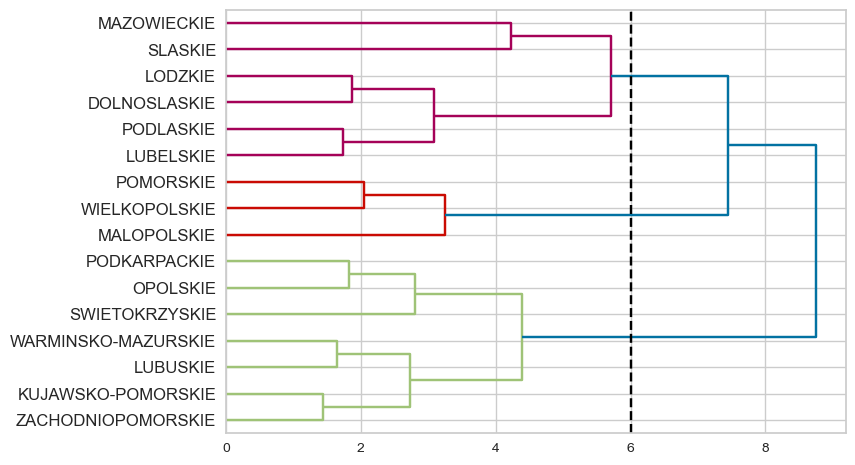

In [185]:
#stworzenie modelu grupowania hierarchicznego
data_linkage = linkage(data_std, method="ward", metric="euclidean")
#stworzenie wykresu dendrogramu razem z linią na poziomie odcięcia
dendrogram(data_linkage, labels=data_std.index, orientation='right')
plt.axvline(x=6,c="black", linestyle="dashed")